In [1]:
import nltk
import string
import torch
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import math

from sentence_transformers import SentenceTransformer, util
# Load the Sentence Transformer model 
model = SentenceTransformer('all-mpnet-base-v2')  

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)


In [2]:
# funzione che rimuove le stopwords, segni di punteggiatura e numeri
def clean_phrase(phrase):
    words = word_tokenize(phrase.lower())
    cleaned_words = [word for word in words if word.lower() not in stop_words and word not in punctuation and not word.isdigit() and word !="''"]
    return cleaned_words

#restituisce il calcolo della cosine similarity tra due blocchi
def cosine_similarity(block1,block2):
    block1 = [clean_phrase(phrase) for phrase in block1]
    block2 = [clean_phrase(phrase) for phrase in block2]
    block1_merged= [word for sublist in block1 for word in sublist]
    block2_merged= [word for sublist in block2 for word in sublist]
    block1_dict = Counter(block1_merged)
    block2_dict = Counter(block2_merged)
    words = list(block1_dict.keys() | block2_dict.keys())
    numerator=0
    denominator_1=0
    denominator_2=0
    for word in words:
        numerator+=block1_dict[word]*block2_dict[word]
        denominator_1 += block1_dict[word]**2  
        denominator_2 += block2_dict[word]**2
    cos_sim=numerator / math.sqrt(denominator_1 * denominator_2)
    return cos_sim

#Calcola la somiglianza tra due liste di stringhe della stessa dimensione usando i Transformers
def sentence_transformer_similarity(block1, block2):
  AGGREGATION="average"
  # Get sentence embeddings
  embeddings1 = model.encode(block1)
  embeddings2 = model.encode(block2)

  # Calculate pairwise cosine similarities
  similarities = util.pytorch_cos_sim(embeddings1, embeddings2)

  # Handle potential empty similarity matrix (all sentences might be identical)
  if similarities.shape[0] == 1 and similarities.shape[1] == 1:
    return similarities.item()

  # Aggregate pairwise similarities
  if AGGREGATION == "average":
    similarity = torch.mean(similarities).item()
  elif AGGREGATION == "max":
    similarity = torch.max(similarities).item()
  else:
    raise ValueError(f"Invalid aggregation method: {AGGREGATION}")

  return similarity   



# trova tutte le occorrenze di '<SECTION_SEP>' in un documento
def find_section_start_indices(text):  
    sections=text.split('<SECTION_SEP>')
    boundaries=[]
    count=0
    for sec in sections[:-1]:
        sentences=sec.split('<SENTENCE_SEP>')
        count+=len(sentences)-1
        boundaries.append(count)
    return boundaries


def plot_similiraty(graph,similarity,smoothed_similarities):
    xpoints = np.arange(len(similarity))
    ypoints = similarity
    xpoints_smooth = np.arange(len(smoothed_similarities))
    ypoints_smooth = smoothed_similarities
    graph.plot(xpoints, ypoints, '-o', color='red', label='Similarities')
    graph.plot(xpoints_smooth, ypoints_smooth, '-o', color='blue', label='Smoothed similarities')
    graph.set_title("Sentence Transformer") 


def get_boundaries(similarities):
    depth_score_sim=[]
    for i in range(1,len(similarities)-1):
        score=(similarities[i-1]-similarities[i])+(similarities[i+1]-similarities[i])
        depth_score_sim.append(score)
    depth_score_sim.insert(0,similarities[1]-similarities[0])
    depth_score_sim.append(similarities[-2]-similarities[-1])

    filtered=list(filter(lambda x: x > 0, depth_score_sim))
    std=np.std(filtered)
    mean=np.mean(filtered)
    threshold=(mean-(std))
    boundaries= [i for i, v in enumerate(depth_score_sim) if v > threshold]
    boundaries = [x+1 for x in boundaries]
    return boundaries

def boundaries_error(actual,predicted,block_len):
  errors=[]
  for boundary in actual:
    min_edit_distance=6000
    for pr in predicted:
      edit_distance=abs(boundary-(pr*block_len))
      if(edit_distance<min_edit_distance):
        min_edit_distance=edit_distance
    errors.append(min_edit_distance)
  return sum(errors)

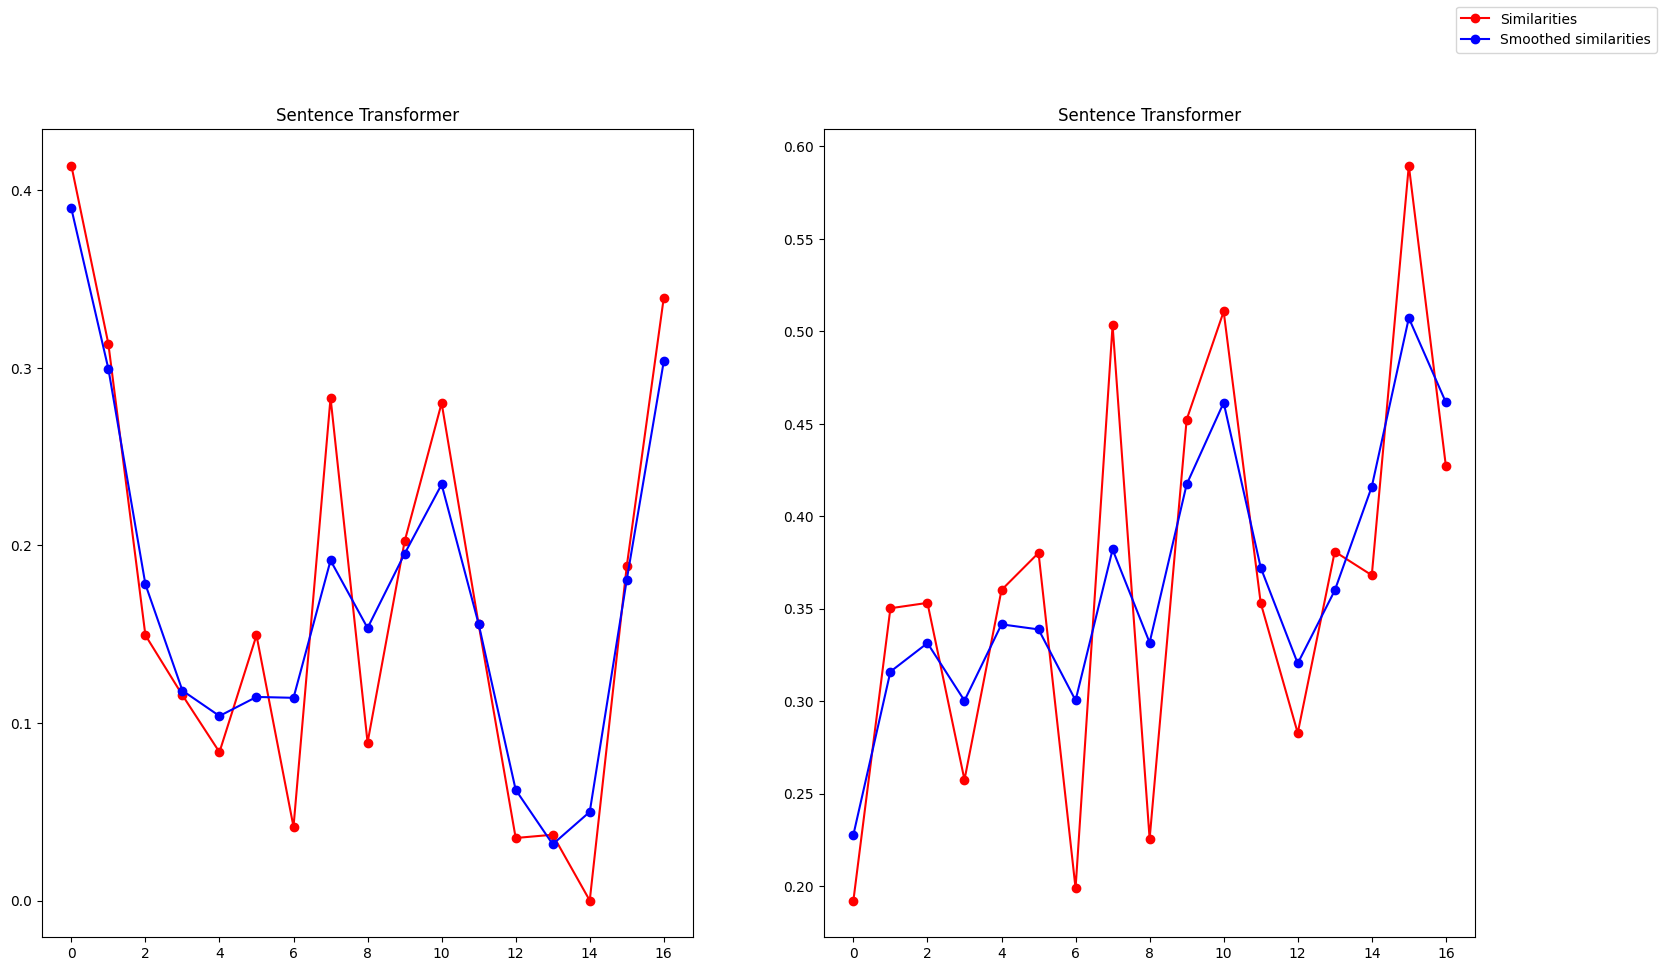

[3, 4, 7, 9, 13, 14, 15]
8
[1, 4, 7, 9, 12, 13, 15, 17]
4
[3, 22, 25]


In [3]:

#numero di frasi considerate in un blocco
N_BLOCK=2
SENT_NUM=1

#contiene i documenti
df = pd.read_csv("data\\definitions_for_filling.csv")  
docs=[df['Definitions'][0],df['Definitions'][1],df['Definitions'][2],df['Definitions'][3]]

#contiene, per ogni documento, gli indici dei separatori di paragrafo
docs_sections=[]
for doc in docs:
    sections_pos=find_section_start_indices(doc)
    docs_sections.append(sections_pos)

#contiene i documenti, ma separati frase per frase
docs_sent_by_sent=[]
for doc in docs:
    doc_t=doc.replace('<SECTION_SEP>','')
    doc_t=doc_t.replace('\r', '').replace('\n', '')
    doc_splitted=doc_t.split('<SENTENCE_SEP>')
    docs_sent_by_sent.append(doc_splitted)

doc=docs_sent_by_sent[SENT_NUM]

blocks = []
for i in range(0, len(doc), N_BLOCK):
    if i + (N_BLOCK-1) < len(doc):
        blocks.append(doc[i:i + N_BLOCK])
    else:
        blocks.append(doc[i:])



#andiamo a calcolare la similarità tra blocchi utilizzando il metodo tradizionale e i trasformers
lexical_similarities=[]
transformer_similarities=[]

for i in range(0,len(blocks)-1):
    lex_similarity=cosine_similarity(blocks[i],blocks[i+1])
    lexical_similarities.append(lex_similarity)
    bert_similarity=sentence_transformer_similarity(blocks[i],blocks[i+1])
    transformer_similarities.append(bert_similarity)



smoothed_lexical_similarities=gaussian_filter1d(lexical_similarities, sigma=0.7)
smoothed_transformer_similarities=gaussian_filter1d(transformer_similarities, sigma=0.7)

figure, axis = plt.subplots(1, 2) 
figure.set_size_inches(18.5, 10.5)

plot_similiraty(axis[0],lexical_similarities,smoothed_lexical_similarities)
plot_similiraty(axis[1],transformer_similarities,smoothed_transformer_similarities)


figure.legend(['Similarities','Smoothed similarities'])
plt.show()


boundaries=get_boundaries(smoothed_lexical_similarities)
print(boundaries)
print(boundaries_error(docs_sections[SENT_NUM],boundaries,N_BLOCK))

boundaries=get_boundaries(smoothed_transformer_similarities)
print(boundaries)
print(boundaries_error(docs_sections[SENT_NUM],boundaries,N_BLOCK))

print(docs_sections[SENT_NUM])
